# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [1]:
#!pip install networkx==2.3

In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from sklearn.manifold import TSNE

In [3]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [4]:
edges = [tuple(x) for x in data.values.tolist()]

In [5]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [6]:
# https://stackoverflow.com/questions/61154740/attributeerror-module-networkx-has-no-attribute-connected-component-subgraph
A = (B.subgraph(c) for c in nx.connected_components(B))
A = list(A)[0]

In [7]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


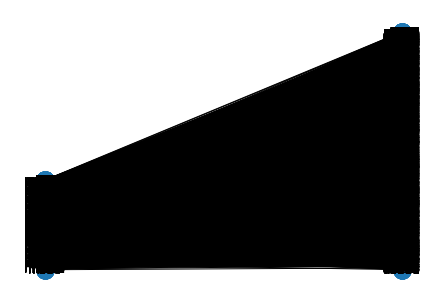

In [8]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [9]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [10]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [11]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [12]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [13]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

In [14]:
len(node_embeddings)

4703

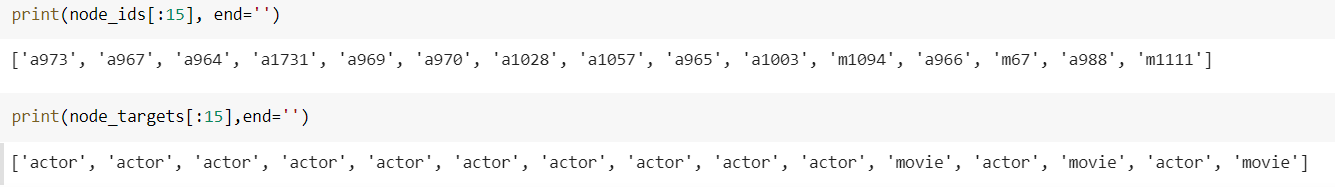

In [15]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for i,label in enumerate(node_targets):
        if str(label) == 'actor':
            actor_nodes.append(node_ids[i])
            actor_embeddings.append(node_embeddings[i])
        if str(label) == 'movie':
            movie_nodes.append(node_targets[i])
            movie_embeddings.append(node_embeddings[i])

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [16]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [17]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [18]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [19]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    largest_con_component = max(nx.connected_components(graph),key=len)
    number_of_nodes_largest_component = len(largest_con_component)
    total_nodes = len(graph.nodes())
    cost1=(number_of_nodes_largest_component/total_nodes)/(number_of_clusters) # calculate cost1 
    return cost1

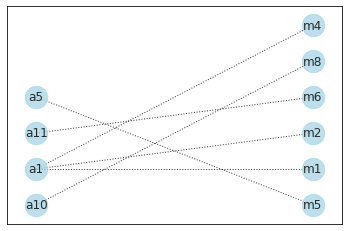

In [20]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [21]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [22]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    num_of_degrees=len(graph.edges())   #As this is bipartitate graph, sum of degrees of one type of nodes = number of edges
    unique_movie_nodes= set()
    for node_names in graph.nodes:
        if 'm' in node_names:
            unique_movie_nodes.add(node_names)
    
    number_of_unique_movie_nodes = len(unique_movie_nodes)
    
    cost2= (num_of_degrees/number_of_unique_movie_nodes)/number_of_clusters
    
    return cost2

In [23]:
# Cost 2 function for clustering movies in Task 2
def cost2_fun_movies(graph,number_of_clusters):
    num_of_degrees=len(graph.edges())  #As this is bipartitate graph, sum of degrees of one type of nodes = number of edges
    unique_actor_nodes= set()
    for node_names in graph.nodes:
        if 'a' in node_names:
            unique_actor_nodes.add(node_names)
    
    number_of_unique_actor_nodes = len(unique_actor_nodes)
    cost2= (num_of_degrees/number_of_unique_actor_nodes)/number_of_clusters
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [24]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [25]:
cluster_sizes_list = [3,5,10,15,20,25,30,50,100,200,500]
for cluster_size in cluster_sizes_list:
    cost1_val = 0
    cost2_val = 0
    kmeans = KMeans(n_clusters = cluster_size,random_state=0)
    kmeans.fit(actor_embeddings)
    labels = kmeans.labels_
    for cluster in range(cluster_size):
        cluster_nodes = []
        G=nx.Graph()
        for idx, label in enumerate(labels):
            if cluster== label:
                cluster_nodes.append(actor_nodes[idx])
        for node in cluster_nodes:
            sub_graph=nx.ego_graph(B,node)
            if str(node)[0] == 'a':
                    G.add_nodes_from(sub_graph.nodes,bipartitate=0)
            if str(node)[0] == 'm':
                    G.add_nodes_from(sub_graph.nodes,bipartitate=1)
            G.add_edges_from(sub_graph.edges())
        
        cost1_val += cost1(G,cluster_size)
        cost2_val += cost2(G,cluster_size)
    final_cost = cost1_val * cost2_val
    print("For cluster size {}, the final cost is {}".format(cluster_size, final_cost))
                
            

For cluster size 3, the final cost is 3.701523140634521
For cluster size 5, the final cost is 3.0192961875543656
For cluster size 10, the final cost is 2.415718065655232
For cluster size 15, the final cost is 2.0539187179447826
For cluster size 20, the final cost is 1.8605703492418395
For cluster size 25, the final cost is 1.7764917619965603
For cluster size 30, the final cost is 1.665786476421417
For cluster size 50, the final cost is 1.5195568197491849
For cluster size 100, the final cost is 1.5968306146605515
For cluster size 200, the final cost is 1.7510113822505293
For cluster size 500, the final cost is 1.8245615774415576


#### We get the max cost value at number of clusters =3, so we will choose k=3

In [26]:
kmeans = KMeans(n_clusters = 3,random_state=0)
kmeans.fit(actor_embeddings)
labels = kmeans.labels_

<font color='blue'>Displaying similar actor clusters</font>

In [27]:
#Code for displaying similar actor clusters is copied from Clustering_Assignment_Reference.ipynb notebook
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)

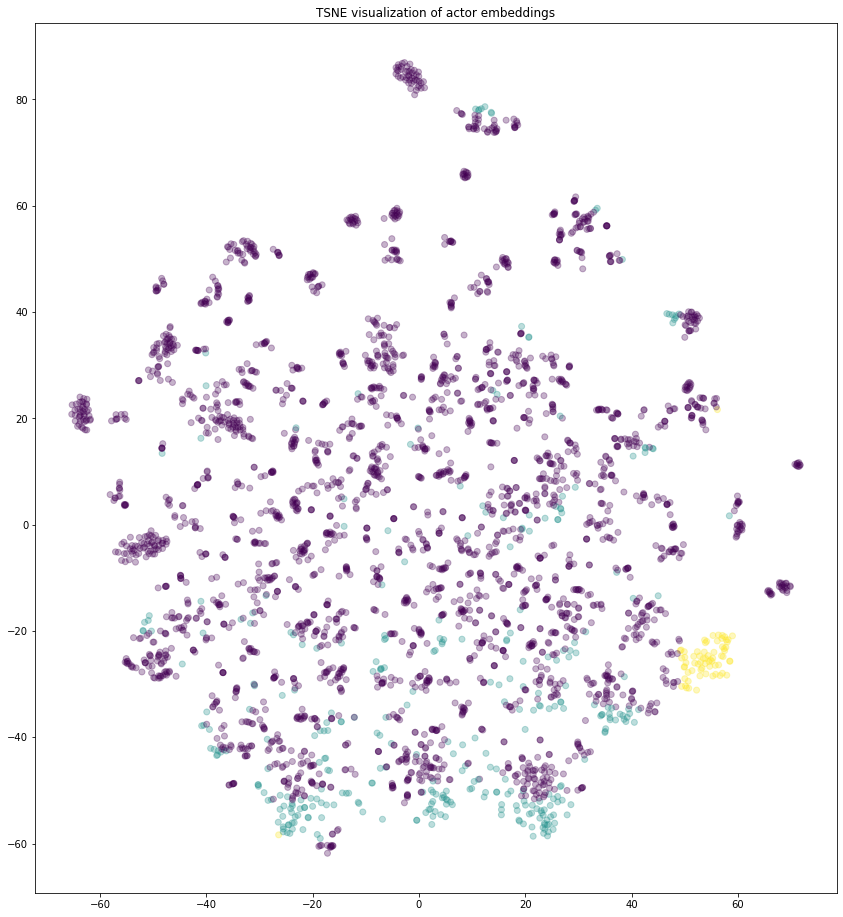

In [28]:
# draw the points

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=labels, alpha=0.3)
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()

<font color='blue'>Grouping similar movies</font>

In [29]:
cluster_sizes_list = [3,5,10,15,20,25,30,50,100,200,500]
for cluster_size in cluster_sizes_list:
    cost1_val = 0
    cost2_val = 0
    kmeans = KMeans(n_clusters = cluster_size,random_state=0)
    kmeans.fit(movie_embeddings)
    labels = kmeans.labels_
    for cluster in range(cluster_size):
        cluster_nodes = []
        G=nx.Graph()
        for idx, label in enumerate(labels):
            if cluster== label:
                cluster_nodes.append(actor_nodes[idx])
        for node in cluster_nodes:
            sub_graph=nx.ego_graph(B,node)
            if str(node)[0] == 'a':
                    G.add_nodes_from(sub_graph.nodes,bipartitate=0)
            if str(node)[0] == 'm':
                    G.add_nodes_from(sub_graph.nodes,bipartitate=1)
            G.add_edges_from(sub_graph.edges())
        
        cost1_val += cost1(G,cluster_size)
        cost2_val += cost2_fun_movies(G,cluster_size)
    final_cost = cost1_val * cost2_val
    print("For cluster size {}, the final cost is {}".format(cluster_size, final_cost))
                
            

For cluster size 3, the final cost is 7.513999199311076
For cluster size 5, the final cost is 7.9357225551681365
For cluster size 10, the final cost is 7.435004998662899
For cluster size 15, the final cost is 10.953267779254483
For cluster size 20, the final cost is 10.1941182594662
For cluster size 25, the final cost is 10.938042191362634
For cluster size 30, the final cost is 14.740393052920378
For cluster size 50, the final cost is 16.58584782091887
For cluster size 100, the final cost is 15.248441707687984
For cluster size 200, the final cost is 14.315228137784995
For cluster size 500, the final cost is 9.368785592112095


### We got max cost at number of clusters = 50, so we choose k = 50

In [33]:
kmeans = KMeans(n_clusters = 50,random_state=0)
kmeans.fit(movie_embeddings)
labels = kmeans.labels_

<font color='blue'>Displaying similar movie clusters</font>

In [34]:
#Code for displaying similar actor clusters is copied from Clustering_Assignment_Reference.ipynb notebook
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)

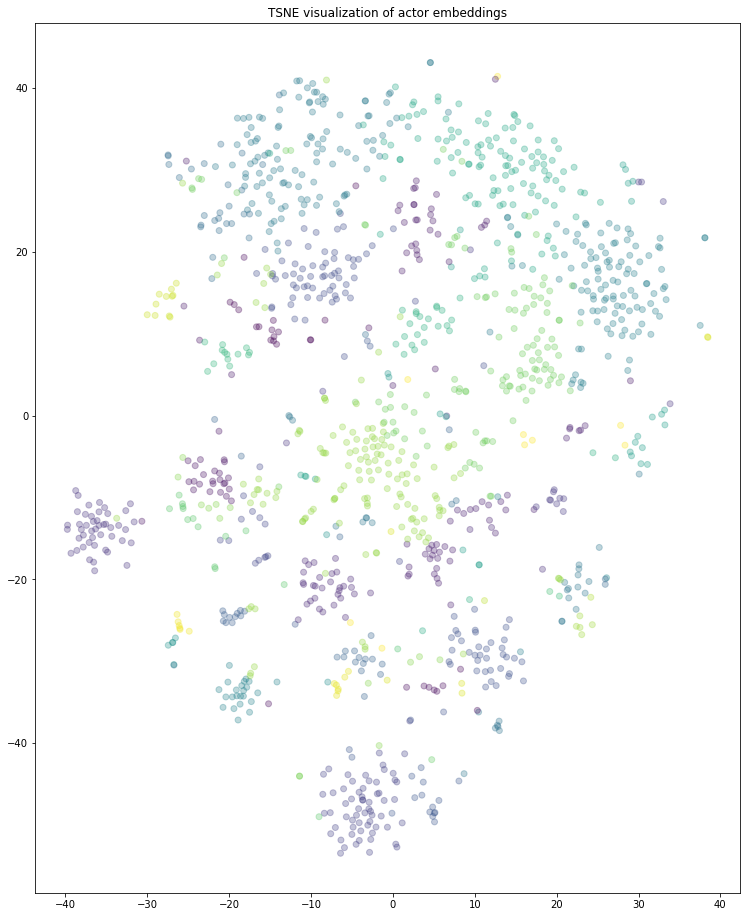

In [35]:
# draw the points

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=labels, alpha=0.3)
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()